#### Notes

In order to change the parameter `a` that controls how the sampler moves during its walk, you need to update the `emcee` package to the most recent version. To do this, run `pip install --upgrade emcee`.

Note that older notebooks will not work with this newer version, but any code that uses `fit2d` to run the MCMC will handle the version change. If you really need to run an older notebook (though it should be easy to port those parameters to a notebook based off this one) you can downgrade the version using `pip install emcee==2.2.1`.

This notebook, and any other code using `fit2d`, can run on the older version of emcee but you won't be able to change the move parameter. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


from fit2d import Galaxy, RingModel
from fit2d.mcmc import LinearPrior
from fit2d.mcmc import emcee_lnlike, piecewise_start_points
from fit2d.models import PiecewiseModel

from astropy.io import fits
import copy
from datetime import datetime
import glob
import joblib
import numpy as np
import os

import emcee
from emcee import EnsembleSampler, moves


In [2]:
#### Hacky way to get modeled 2d v field array. Just run for one iteration.

import numpy as np
import time
from typing import Sequence, Callable, Mapping, Union

from fit2d._velocity_field_generator import create_2d_velocity_field
from fit2d.models import Model


def get_modeled_vfield(
    params: np.ndarray,
    model: Model,
    rotation_curve_func_kwargs: Mapping,
    galaxy: Galaxy,
    ring_model: RingModel,
    mask_sigma: float = 1.,
    v_err_2d: np.ndarray = None,
    v_err_const: float = None,
    n_interp_r: int = 150,
    n_interp_theta: int = 150,
    fit_structural_params: Mapping[str, int] = None,
    regularization_coeff: float = 0.,
    return_n_pixels: bool=False,
    fill_nan_value: float=100,
):
    """[summary]
    Args:
        fit_structural_params: dict of structural ring parameter name (as
            specificied in the RingModel) and its corresponding index in
            params to be fit. e.g. if "inc
    Returns:
        [type]: [description]
    """

    if v_err_2d is None and v_err_const is None:
        raise ValueError(
            "Must provide at least one of v_err_const (float) or "
            "v_err_2d (ndarray) to lnlike.")
    elif v_err_2d is not None and v_err_const is not None:
        raise ValueError(
            "Only provide one of v_err_const (float) or "
            "v_err_2d (ndarray) to lnlike; you provided both.")
    params = np.array(params)
    if fit_structural_params:
        inc = params[fit_structural_params["inc"]]
        pos_angle = params[fit_structural_params["pos_angle"]]
        ring_model.update_structural_parameters(inc=inc, pos_angle=pos_angle)
    r_m, v_m = model.generate_1d_rotation_curve(params, **rotation_curve_func_kwargs)
    
    return r_m, v_m, ring_model
    """vlos_2d_model = create_2d_velocity_field(
        radii=r_m,
        v_rot=v_m,
        ring_model=ring_model,
        kpc_per_pixel=galaxy.kpc_per_pixel,
        v_systemic=galaxy.v_systemic,
        image_xdim=galaxy.image_xdim,
        image_ydim=galaxy.image_ydim,
        n_interp_r=n_interp_r,
        n_interp_theta=n_interp_theta,
        mask_sigma=mask_sigma,
    )
    if fill_nan_value:
        vlos_2d_model = np.nan_to_num(vlos_2d_model, nan=fill_nan_value)
    return vlos_2d_model"""


In [3]:

# number of bins in fit
num_bins = 10

# min and max bounds for each bin
vmin, vmax = 0., 200.

# min and max inc, pos angle in RADIANS
inc_min, inc_max = np.radians(25), np.radians(65)
pos_angle_min, pos_angle_max = np.radians(25), np.radians(65)


name = "NGC2366"
distance = 3400. # [kpc]
observed_2d_vel_field_fits_file = f"/Users/stephencoffey/Downloads/little-things/data/{name}_1mom.fits"
# to use the dispersion as a source of errors, provide this file name
observed_2d_dispersion_fits_file = None #"/home/anna/Desktop/fit2d/data/UGC3974_2mom.fits"
deg_per_pixel=4.17e-4
v_systemic= 99.066

ring_param_file = f"/Users/stephencoffey/Downloads/little-things/data/{name}_ring_parameters_rohit.txt"
# x and y dims are switched in ds9 fits display versus np array shape
fits_ydim, fits_xdim = fits.open(observed_2d_vel_field_fits_file)[0].data.shape

mask_sigma=1.
random_seed = 1234

mcmc_nwalkers = 20
mcmc_niter = 1
mcmc_ndim = 3 # Do not change this if fitting one ring at a time. 1 for vel + 2 for inc and pos angle
mcmc_nthreads = 4
# Try increasing stretch scale factor a. version must be >=3 for this to be used.
mcmc_moves = moves.StretchMove(a = 2)  
mcmc_version = float(emcee.__version__[0])

# Option to save every batch_size iterations in case of crash
# Increase this; 2 is a very low value just for testing
batch_size = 1

# option to save outputs in a particular directory
save_dir = None  


### This is where you can provide a 2D array of pixel errors.
### Only one of these should be set- SET THE OTHER TO HAVE value `None`

#### Note the order the parameters are specified in the `ring_param_bounds`:  index 1 corresponds to the inclination, index 2 corresponds to position angle. 

In [4]:
galaxy = Galaxy(
    name=name,
    distance=distance,
    observed_2d_vel_field_fits_file=observed_2d_vel_field_fits_file,
    deg_per_pixel=deg_per_pixel,
    v_systemic=v_systemic, 
    observed_2d_dispersion_fits_file=observed_2d_dispersion_fits_file
)

ring_model = RingModel(
    ring_param_file=ring_param_file,
    fits_xdim=fits_xdim,
    fits_ydim=fits_ydim,
    distance=distance
)
ring_param_bounds = [(vmin, vmax),(inc_min, inc_max), (pos_angle_min, pos_angle_max)]

# mapping of ring struct params to their index in the parameters (same as specified in bounds)
# this is provided as an optional argument to lnlike to tell it which parameters to use as inc and pos_angle
fit_structural_params = {"inc": 1, "pos_angle": 2}

bin_edges = np.linspace(ring_model.radii_kpc[0], ring_model.radii_kpc[-1], num_bins+1)
bin_centers = [(bin_edges[i]+bin_edges[i+1])/2. for i in range(num_bins)]

In [5]:
# One, but not both, should be provided to lnlike

v_err_const = 10. # [km/s] constant error per pixel
v_err_2d = None

# to use the 2nd moment map,
# v_err_const = None
# v_err_2d = galaxy.observed_2d_dispersion

The code below has been altered to change the "observations" to a fake array
with a constant circular velocity at all radii.

Set the variable `v_rot_fake` to the constant velocity


In [6]:
import warnings
warnings.simplefilter('ignore')

v_rot_fake = 40   # fill this in with something within the priors
inc_fake = np.radians(45)  # fill this in with something within the priors
pos_angle_fake = np.radians(45) # fill this in with something within the priors

# if inc and/or pos_angle are not being fit in the MCMC, 
# they will be fixed to constant values inc_fake, pos_angle_fake
ring_model.update_structural_parameters(inc=inc_fake, pos_angle=pos_angle_fake)

def Analysis(bin_index):
    bin_min, bin_max = bin_edges[0], bin_edges[-1]
    
    
    # the block here replaces the observed galaxy velocity field data with "fake" disk of
    # constant rotational velocity v_rot_fake
    fake_observed_2d_vel_field =create_2d_velocity_field(
        radii = [bin_min, bin_max],
        v_rot = [v_rot_fake, v_rot_fake],  # just fill in any velocity
        ring_model = ring_model,
        kpc_per_pixel = galaxy.kpc_per_pixel,
        v_systemic = galaxy.v_systemic,
        image_xdim = galaxy.image_xdim,
        image_ydim = galaxy.image_ydim
    )
    galaxy.observed_2d_vel_field = fake_observed_2d_vel_field

    plt.imshow(galaxy.observed_2d_vel_field)
    plt.title("Fake data")
    
    piecewise_model = PiecewiseModel(num_bins=1)
    piecewise_model.set_bounds(array_bounds=ring_param_bounds)
    piecewise_model.set_bin_edges(rmin=bin_min, rmax=bin_max)
    radii_to_interpolate = np.array([r for r in ring_model.radii_kpc if bin_min<r<bin_max])                              

    prior = LinearPrior(bounds=piecewise_model.bounds)
    prior_transform = prior.transform_from_unit_cube
    start_positions = piecewise_start_points(mcmc_nwalkers, piecewise_model.bounds, random_seed=random_seed)  
    fit_inputs = {
        "piecewise_model": piecewise_model,
        "galaxy": galaxy,
        "ring_model": ring_model,
        "prior_transform": prior_transform
    }
    
    print(f"Fitting ring {bin_index}")
    
    rotation_curve_func_kwargs = {
        "radii_to_interpolate": radii_to_interpolate}

    lnlike_args = {
        "model": piecewise_model,
        "rotation_curve_func_kwargs": rotation_curve_func_kwargs, 
        "galaxy": galaxy, 
        "ring_model": ring_model, 
        "mask_sigma": mask_sigma,
        "v_err_const": v_err_const,
        "v_err_2d": v_err_2d,
        "fit_structural_params": fit_structural_params,
        "fill_nan_value": v_systemic
    }

    params = np.array([v_rot_fake, inc_fake, pos_angle_fake]) # if fitting inc and pos angle add those to array in appropriate order
    
    """# measure the time it takes the CPU to construct the velocity field in the current fit2d code (13 Sept 2021)
    start = time.time()"""
    vfield_model = get_modeled_vfield(params, **lnlike_args)
    #time_taken = (time.time() - start)
    #print(f"Time taken: {time_taken}")
    
    #print(f"modeled vs mock observed v field for ring {bin_index}")
    """plt.imshow(vfield_model)
    
    plt.colorbar()
    plt.show()
    plt.imshow(galaxy.observed_2d_vel_field)
    plt.colorbar()
    plt.show()"""
    
    plt.imshow(vfield_model)
    plt.title("Modeled field")
    
    return vfield_model


In [7]:
vfield_model = Analysis(0)

Fitting ring 0


In [8]:
%%timeit
vlos_2d_model = create_2d_velocity_field(
        radii=vfield_model[0],
        v_rot=vfield_model[1],
        ring_model=vfield_model[2],
        kpc_per_pixel=0.025,
        v_systemic=100,
        image_xdim=1024,
        image_ydim=1024,
        n_interp_r=150,
        n_interp_theta=150,
        mask_sigma=1,
    )

2.47 s ± 61.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0.5, 1.0, 'Old vfield code')

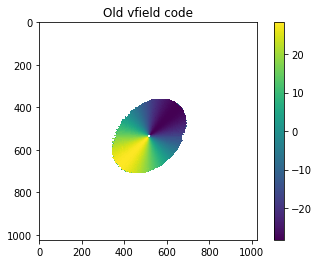

In [12]:
vlos_2d_model = create_2d_velocity_field(
        radii=vfield_model[0],
        v_rot=vfield_model[1],
        ring_model=vfield_model[2],
        kpc_per_pixel=0.025,
        v_systemic=0,
        image_xdim=1024,
        image_ydim=1024,
        n_interp_r=150,
        n_interp_theta=150,
        mask_sigma=1,
    )
plt.imshow(vlos_2d_model)
plt.colorbar()
plt.title("Old vfield code")

Text(0.5, 1.0, 'Old vfield code')

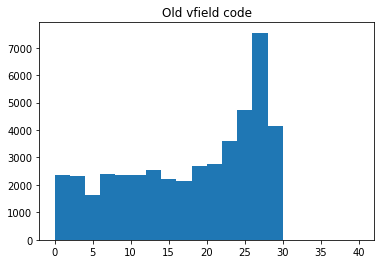

In [11]:
plt.hist(vlos_2d_model.flatten(), bins = 20, range = (0,40))
plt.title("Old vfield code")